Plots visualizations of how different subject/encounter numbers compare to each other for the main conditions of each task/contrast for several Yeo networks.

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [13]:
# constants
RSM_file = 'complete_rsm_results.pkl'

# yeo labels
network_names = {
    1: "Visual",
    2: "Somatomotor",
    3: "Dorsal Attention",
    4: "Ventral Attention",
    5: "Limbic",
    6: "Frontoparietal Control",
    7: "Default Mode"
}

# main conditions and contrasts that we're interested in looking at
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = ["twoBack-oneBack"]
requested_task_contrasts['flanker'] = ["incongruent-congruent"]
requested_task_contrasts['directedForgetting'] = ["neg-con"]
requested_task_contrasts['goNogo'] = ["nogo_success-go"]
requested_task_contrasts['shapeMatching'] = ["main_vars"]
requested_task_contrasts['stopSignal'] = ["stop_failure-go"]
requested_task_contrasts['stopSignal'] = ["stop_success-go"]
requested_task_contrasts['cuedTS'] = ["task_switch_cost"]
requested_task_contrasts['spatialTS'] = ["task_switch_cost"]

# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline", "incongruent-congruent","response_time"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

In [4]:
# helper function
def load_rsm(filename):
    """
    Simple load function
    
    Parameters:
        filename: filename to load
    
    Returns:
        rsm_results: Loaded RSM dictionary
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    with open(filename, 'rb') as f:
        rsm_results = pickle.load(f)
    
    print(f"Loaded from {filename}")
    return rsm_results


In [7]:
# load all of the calculated RSMs (this includes each subj/encounter/task/contrast for the whole brain and every yeo network

if os.path.exists("complete_rsm_results.pkl"):
    print("File exists!")
    all_rsms = load_rsm("complete_rsm_results")
else:
    print("ERROR does not exist; go back to 3_create_RSMs_first_level.ipyn")

File exists!
Loaded from complete_rsm_results.pkl


## Basic visualization

In [8]:
def plot_rsm_clean(all_rsms, task, contrast, region, figsize=(15, 15), 
                         show_subject_only=False, show_encounter_only=False):
    """
    Plot RSM with simple labels
    
    Parameters:
        show_subject_only: Only show subject IDs
        show_encounter_only: Only show encounter numbers
    """
    
    try:
        rsm_data = all_rsms[task][contrast][region]
        rsm_matrix = rsm_data['rsm']
        title = rsm_data["full_title"]
        descriptors = rsm_data.get('descriptors', None)
    except KeyError:
        print(f"Error: Could not find {task}/{contrast}/{region}")
        return
    
    # Create simplified labels
    if descriptors:
        if show_subject_only:
            # Extract just subject IDs
            labels = []
            for desc in descriptors:
                # Assuming format like "sub01:task:contrast:encounter-01"
                parts = desc.split(':')
                subject = parts[0] if parts else f"Map{len(labels)+1}"
                labels.append(subject)
        
        elif show_encounter_only:
            # Extract just encounter numbers
            labels = []
            for desc in descriptors:
                if 'encounter' in desc:
                    encounter_part = desc.split('encounter-')[-1]
                    labels.append(f"E{encounter_part}")
                else:
                    labels.append(f"E{len(labels)+1}")
        else:
            # Use full descriptors
            labels = descriptors
    else:
        labels = [f"Map {i+1}" for i in range(rsm_matrix.shape[0])]
        
    mask = np.eye(rsm_matrix.shape[0], dtype=bool)
    rsm_masked = np.ma.masked_array(rsm_matrix, mask=mask)
            
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(rsm_masked, cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal')

    # add corr labels
    for i in range(rsm_masked.shape[0]):
        for j in range(rsm_masked.shape[1]):
            # if j > i:
            if i!=j:
                value = rsm_masked[i, j]
                
                text_color = 'white' if abs(value) > 0.5 else 'black'
                
                # Format the value
                value_str = f'{value:.{2}f}'
                
                ax.text(j, i, value_str, ha='center', va='center', 
                       color=text_color, fontsize=9)
        
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.6)
    cbar.set_label('Correlation')
    
    # Set labels
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(labels, fontsize=12)
    
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

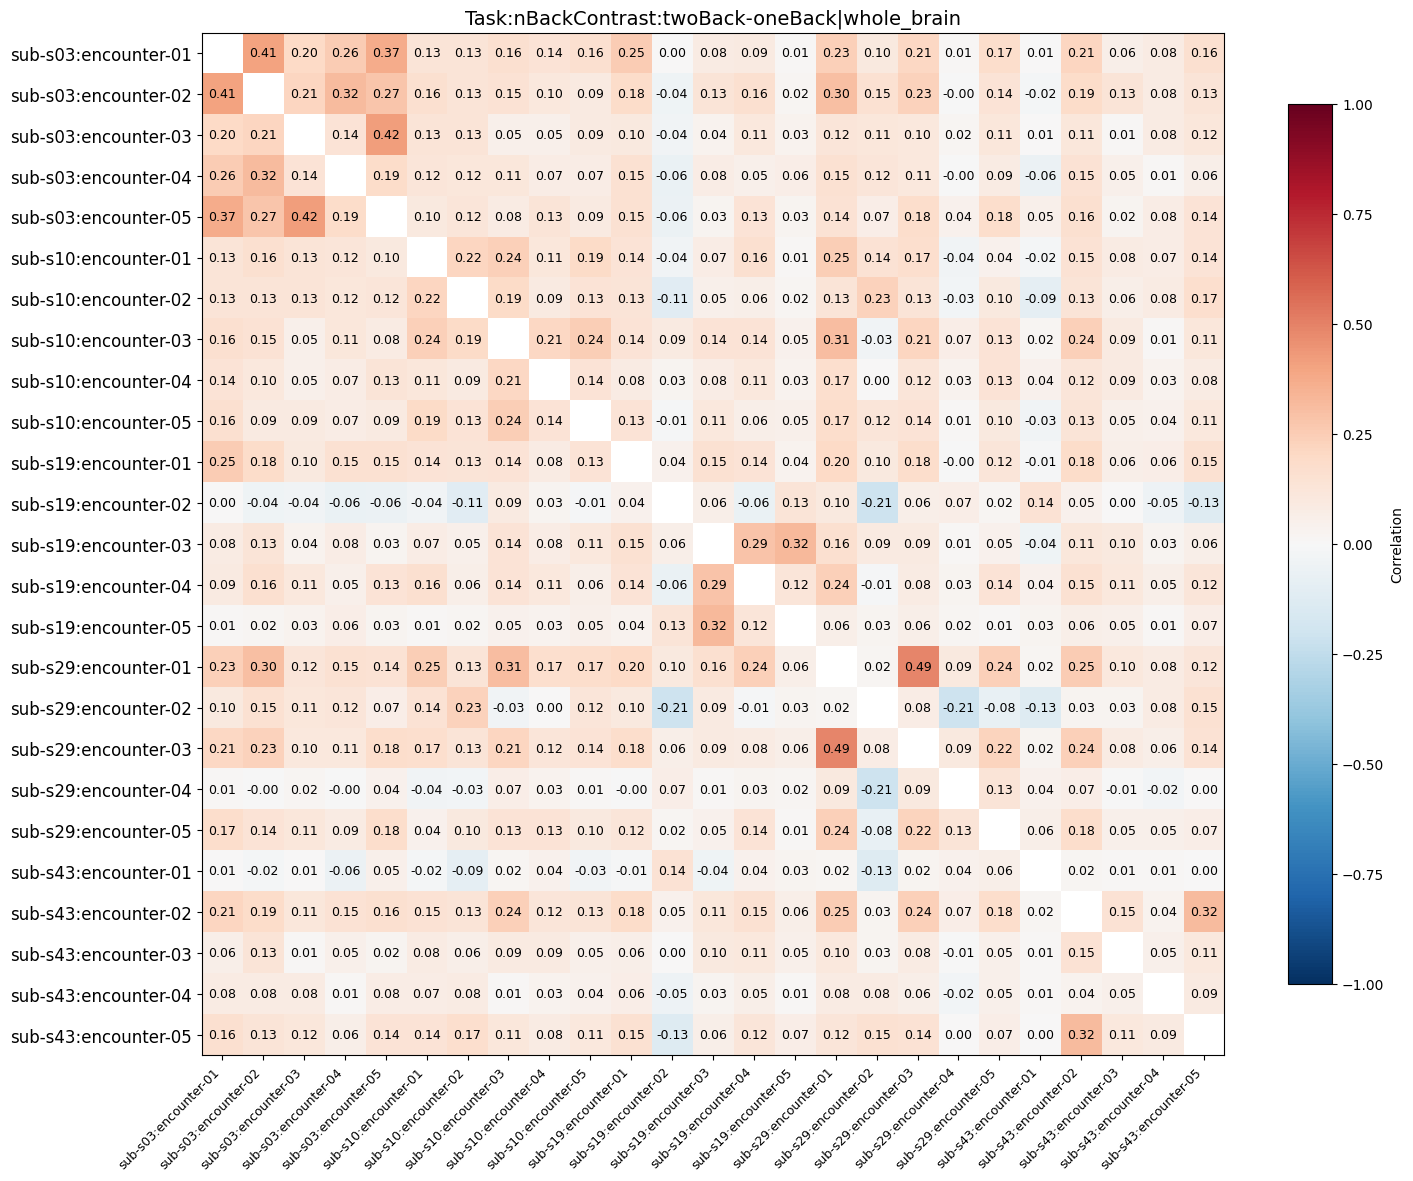

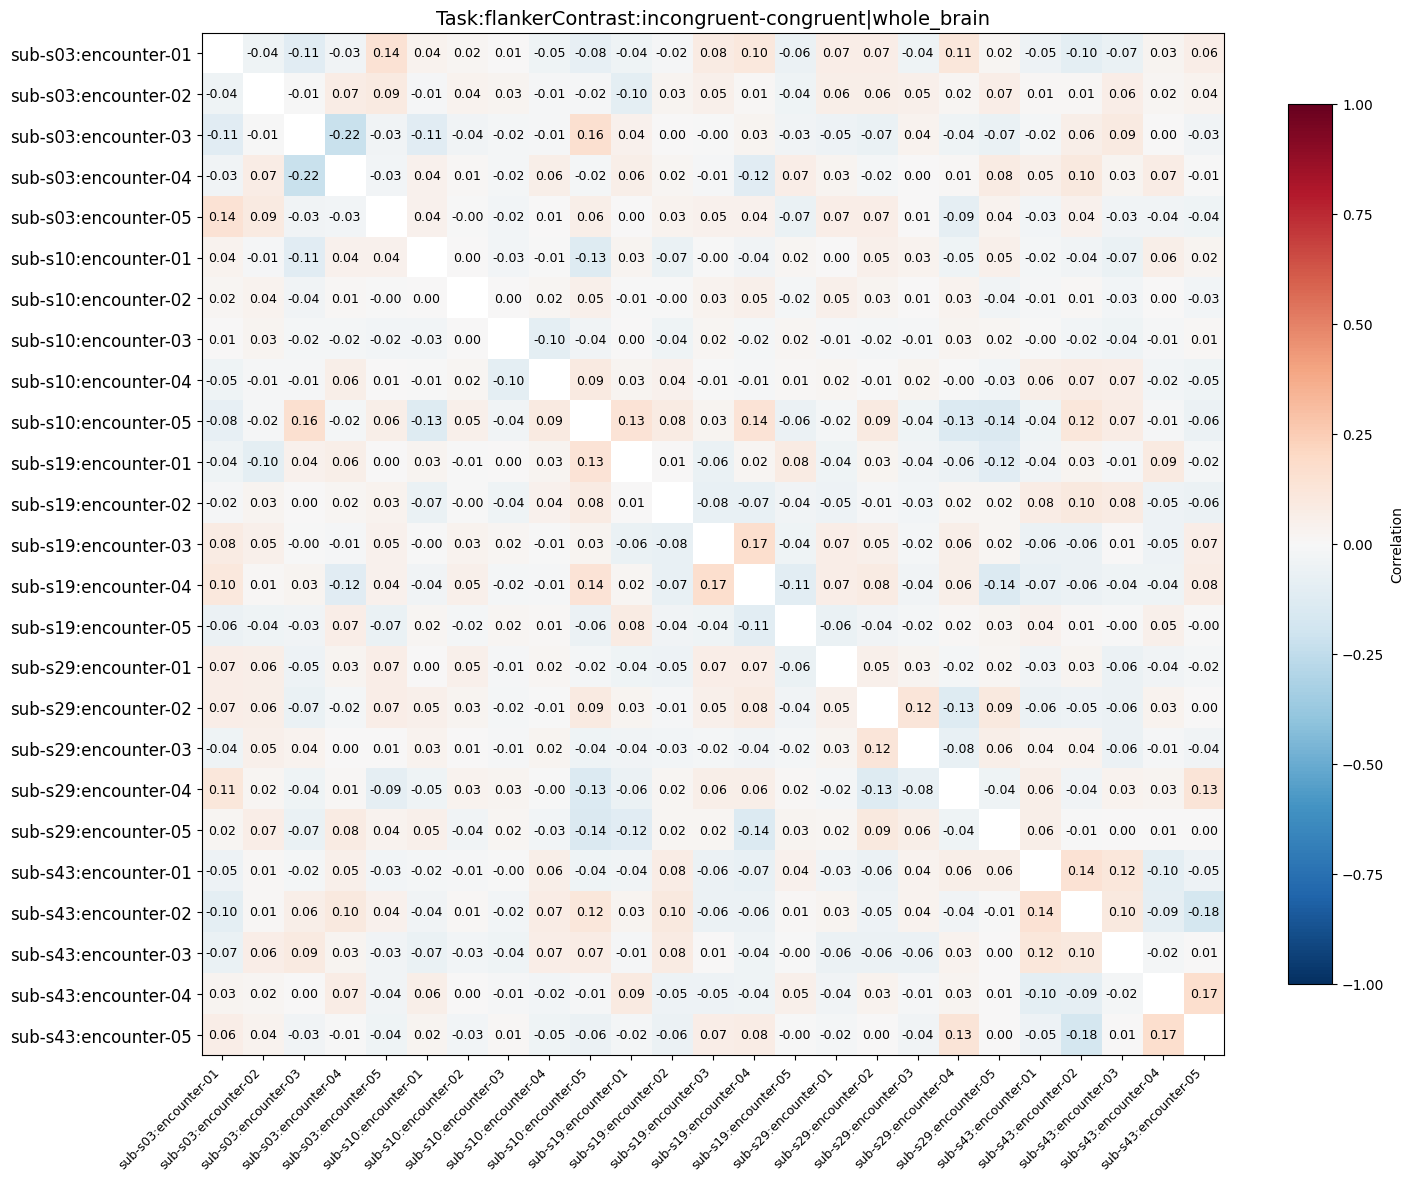

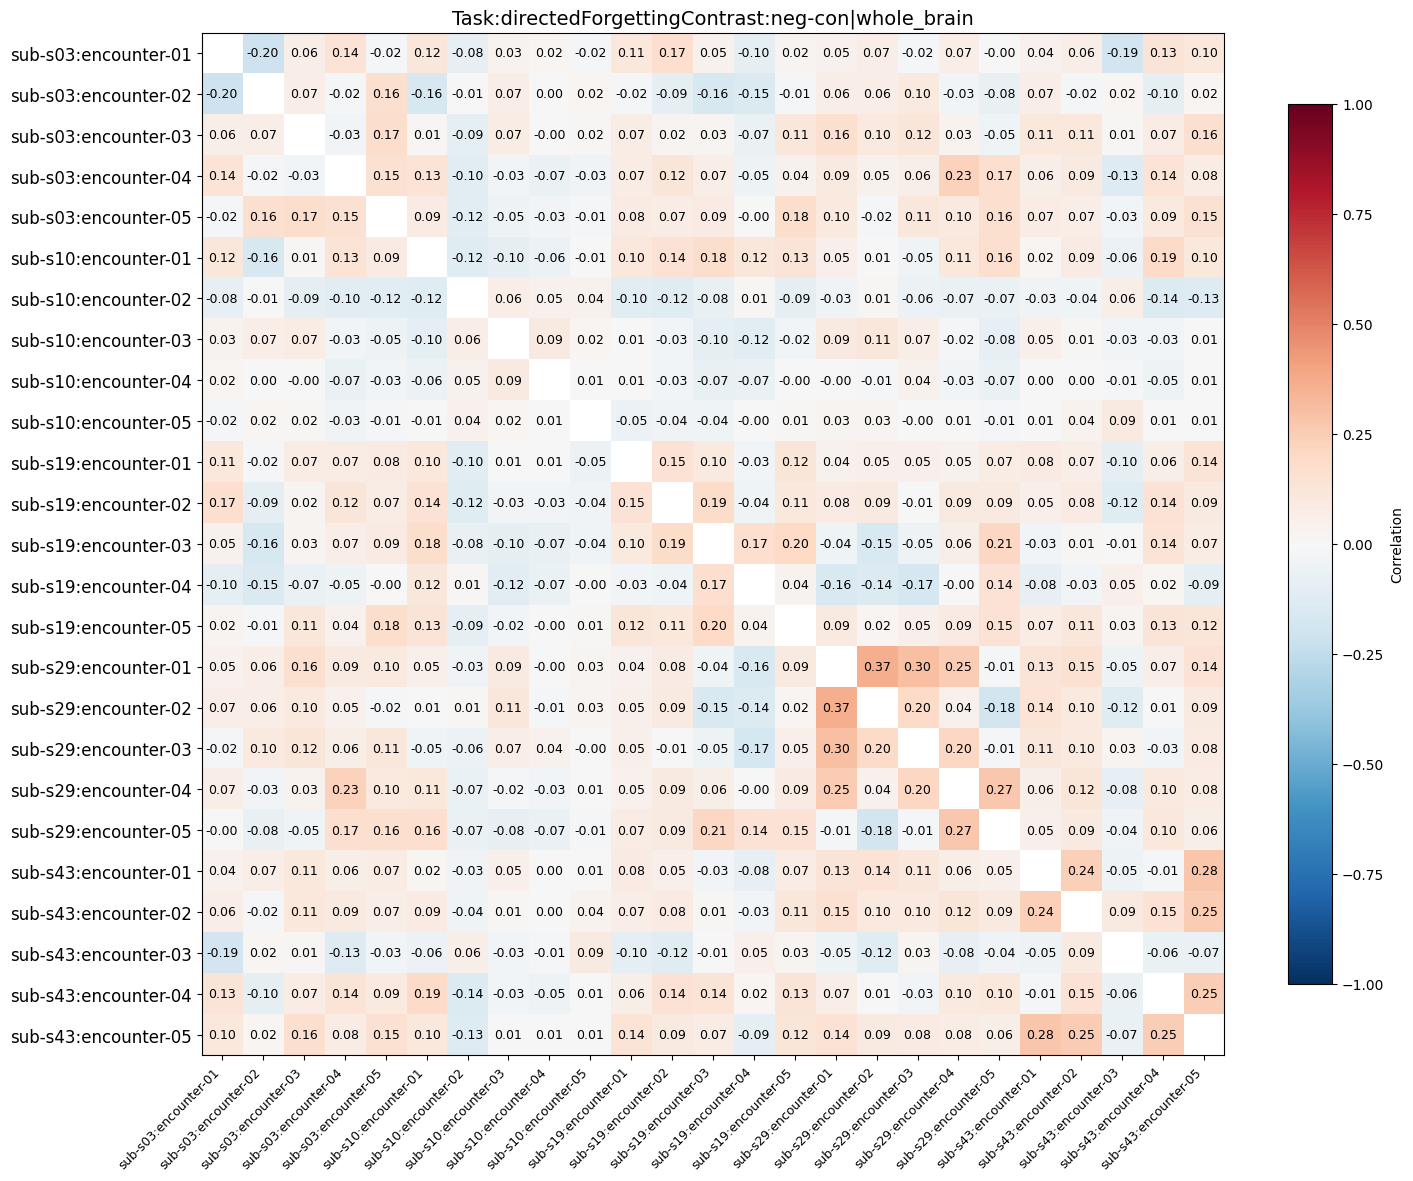

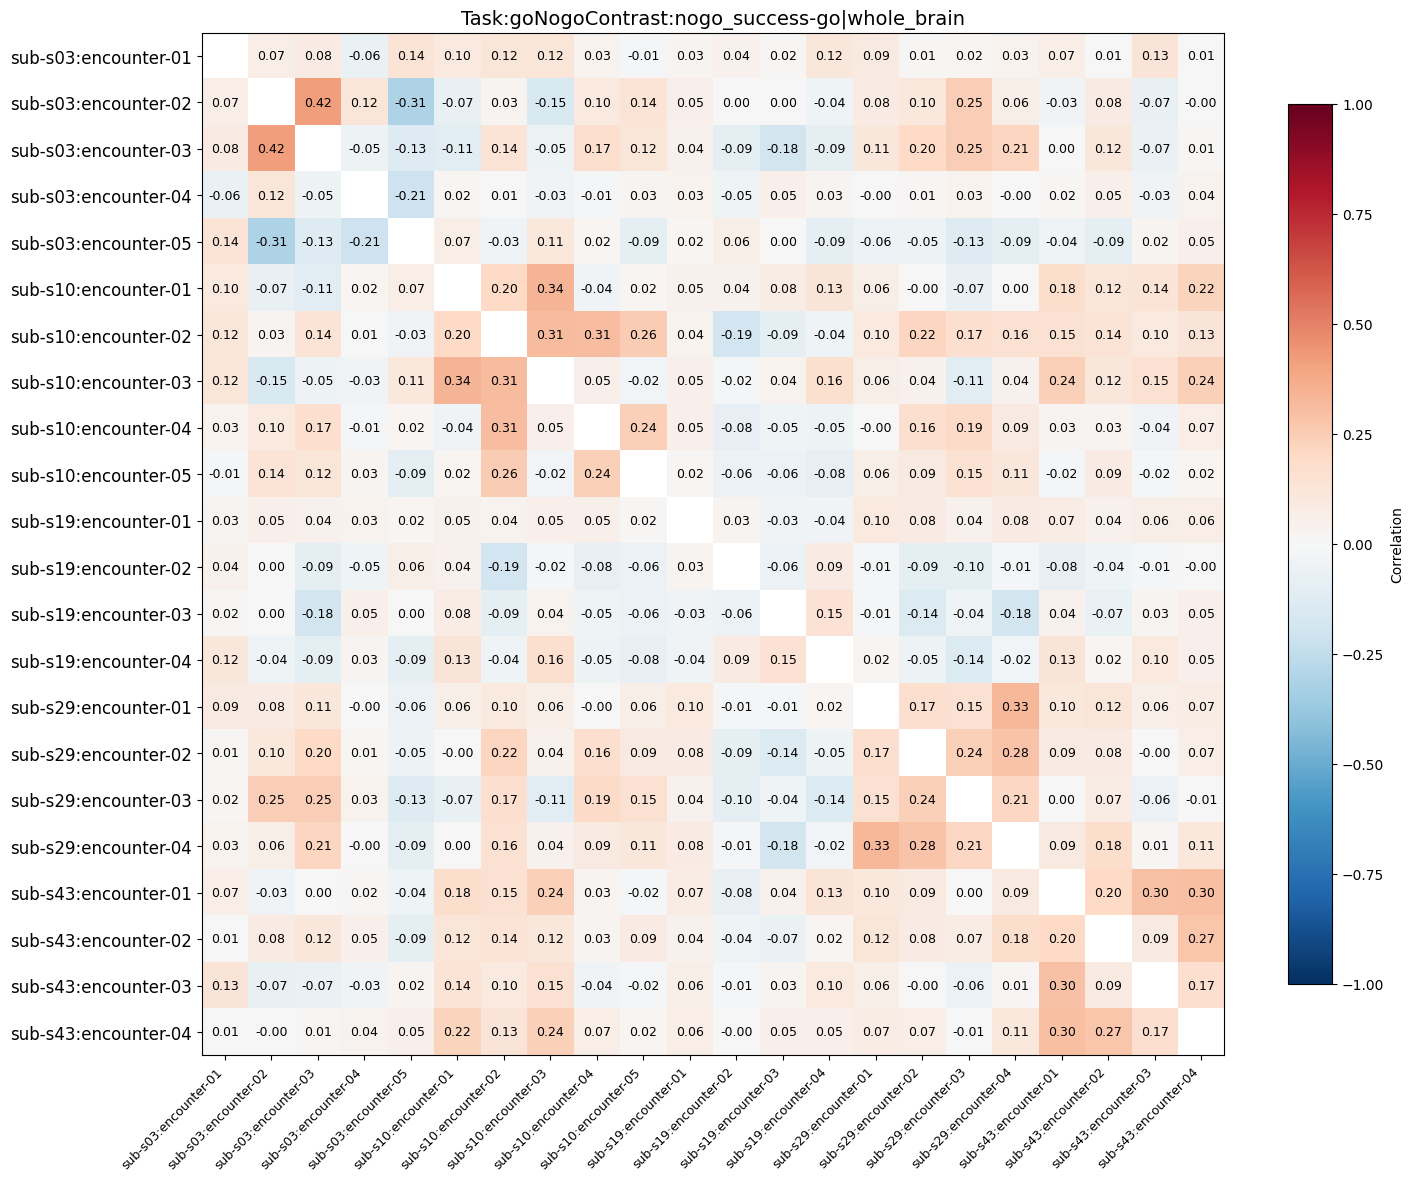

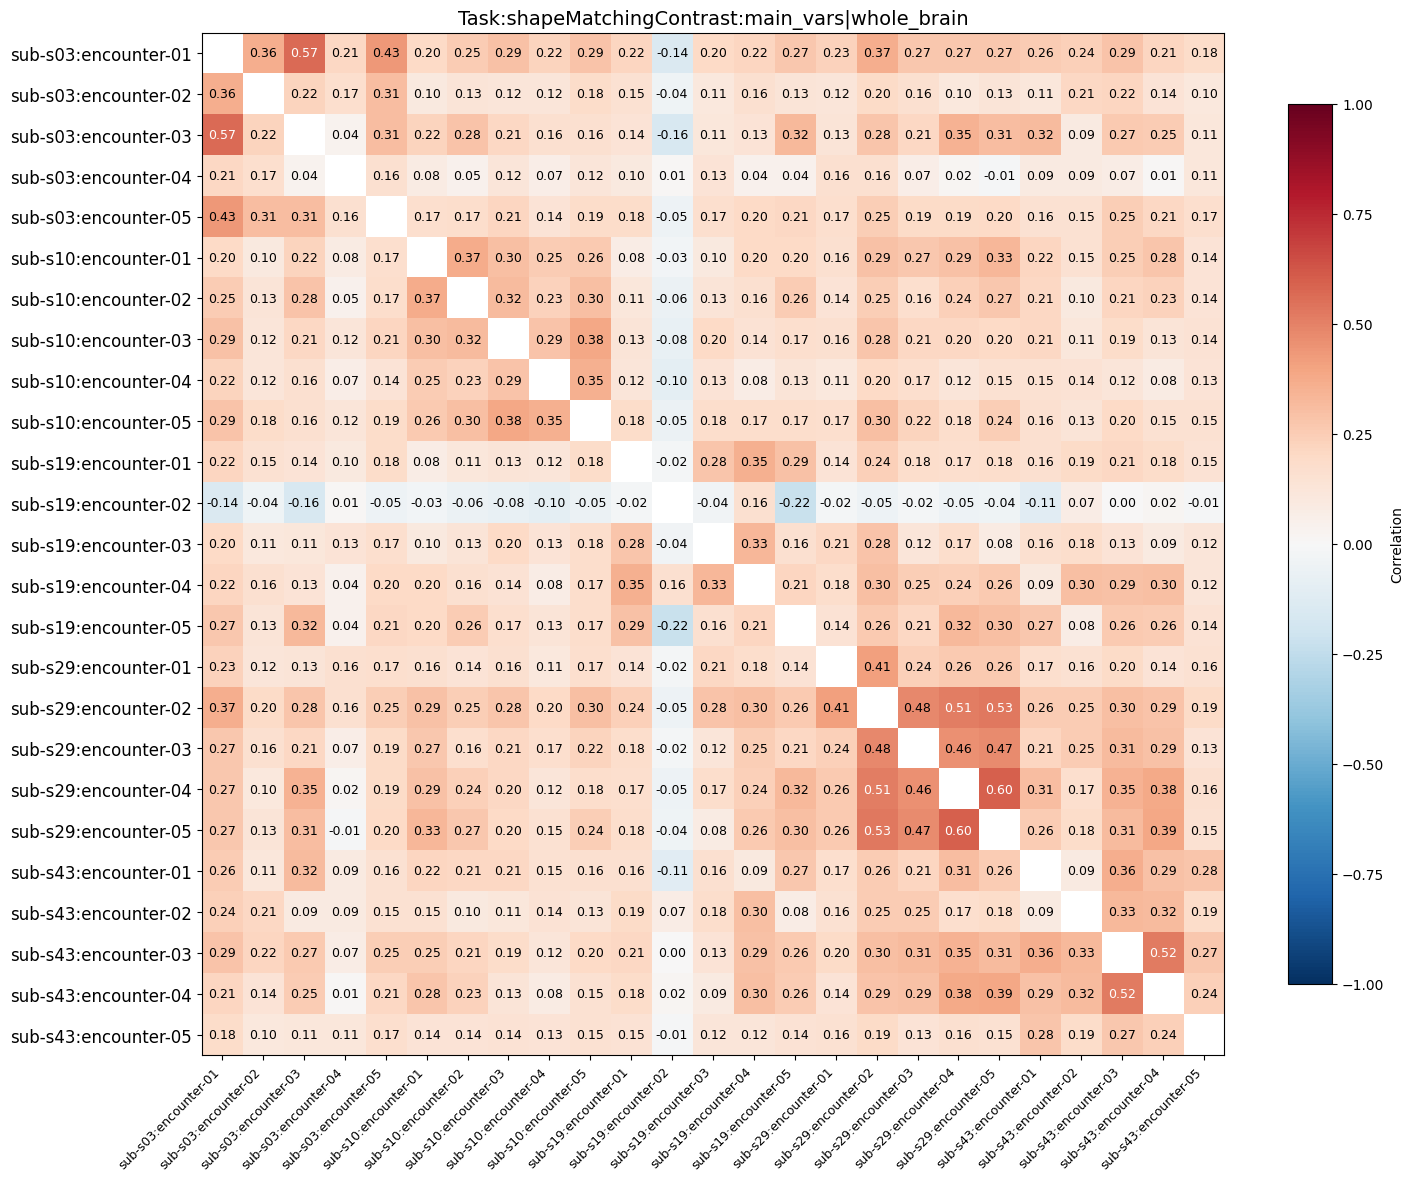

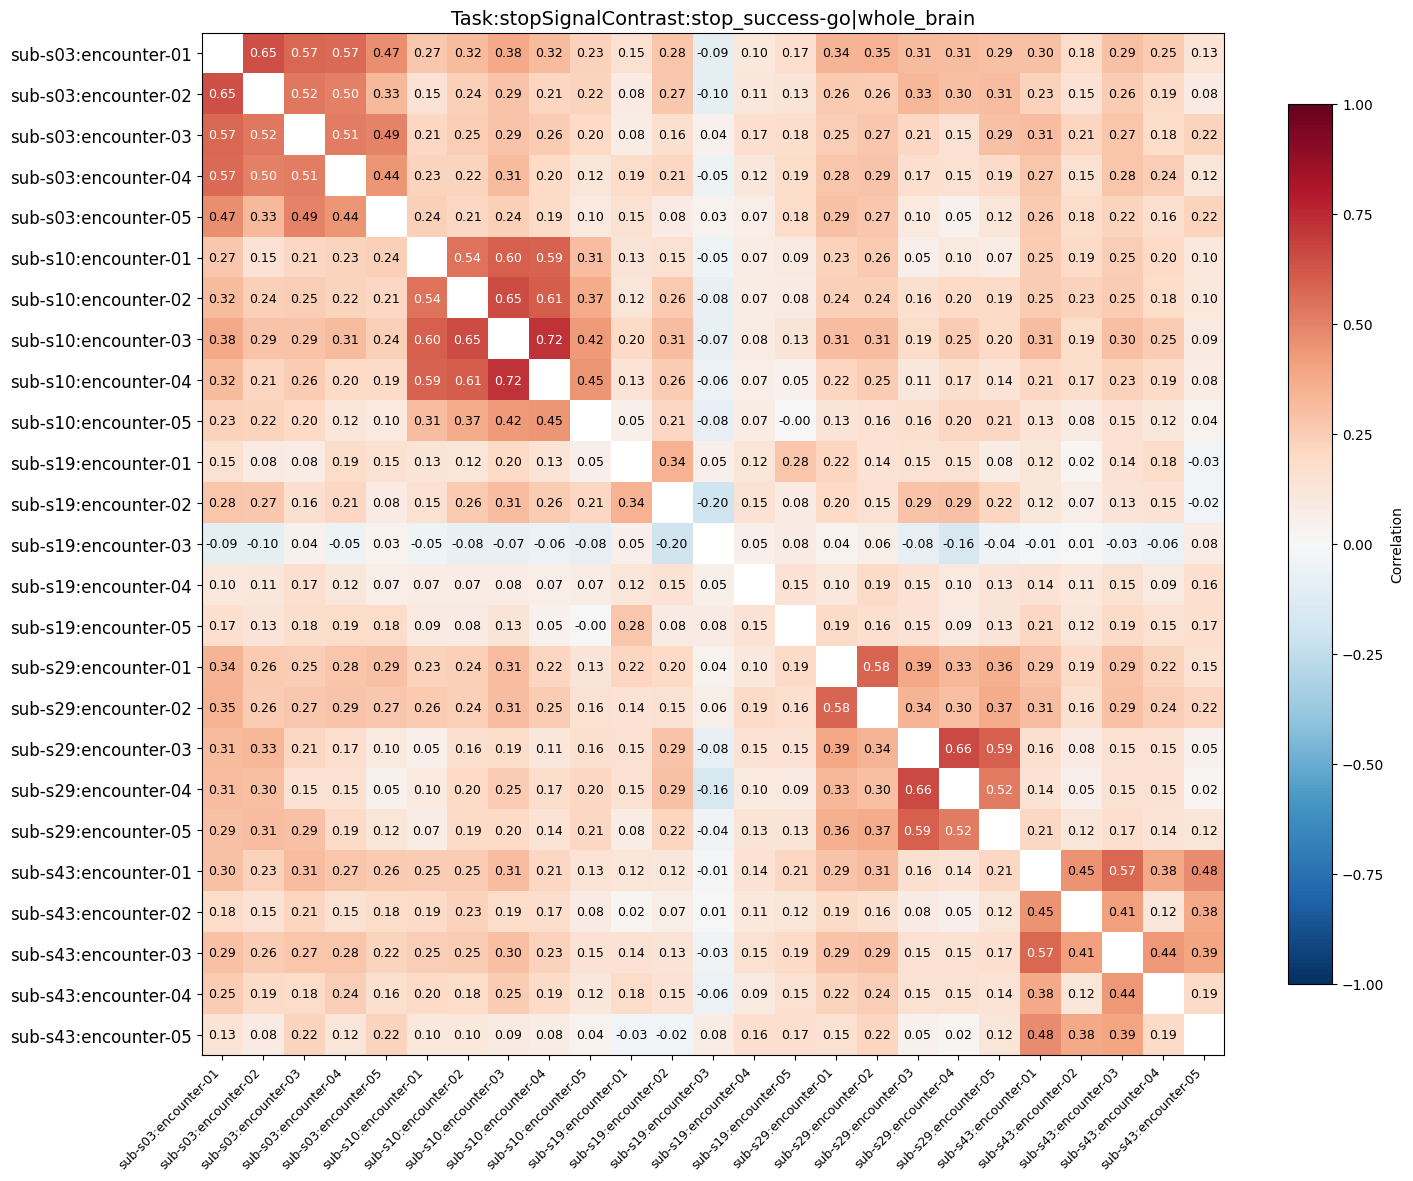

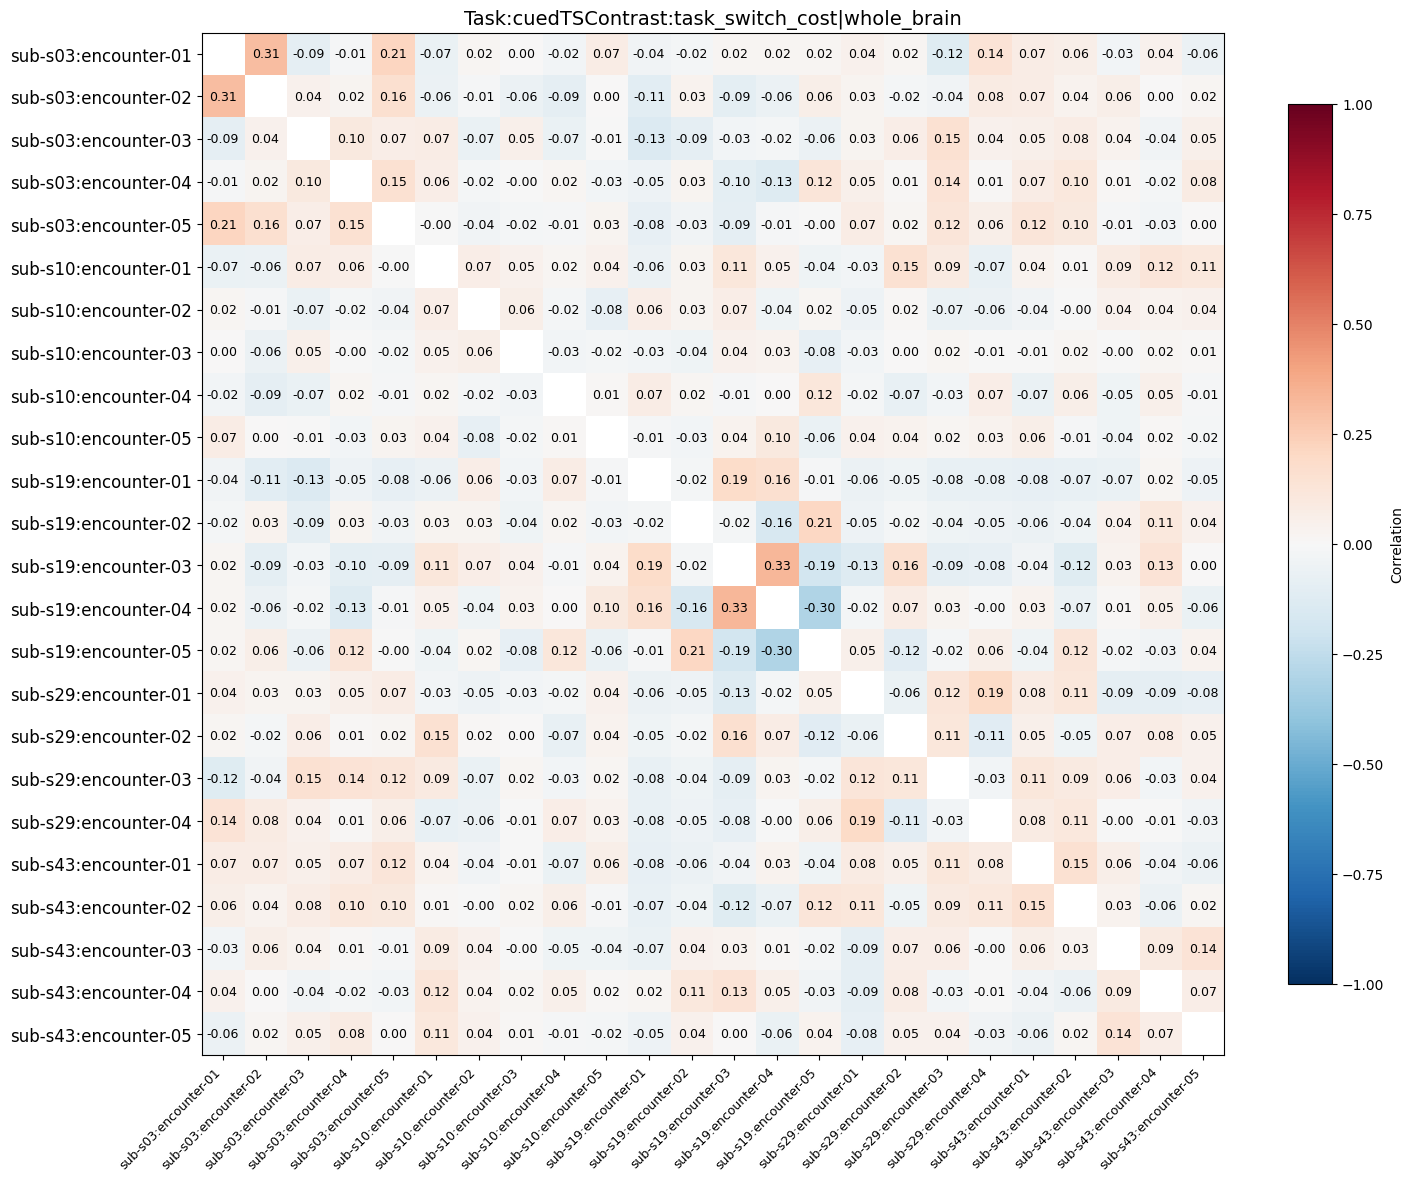

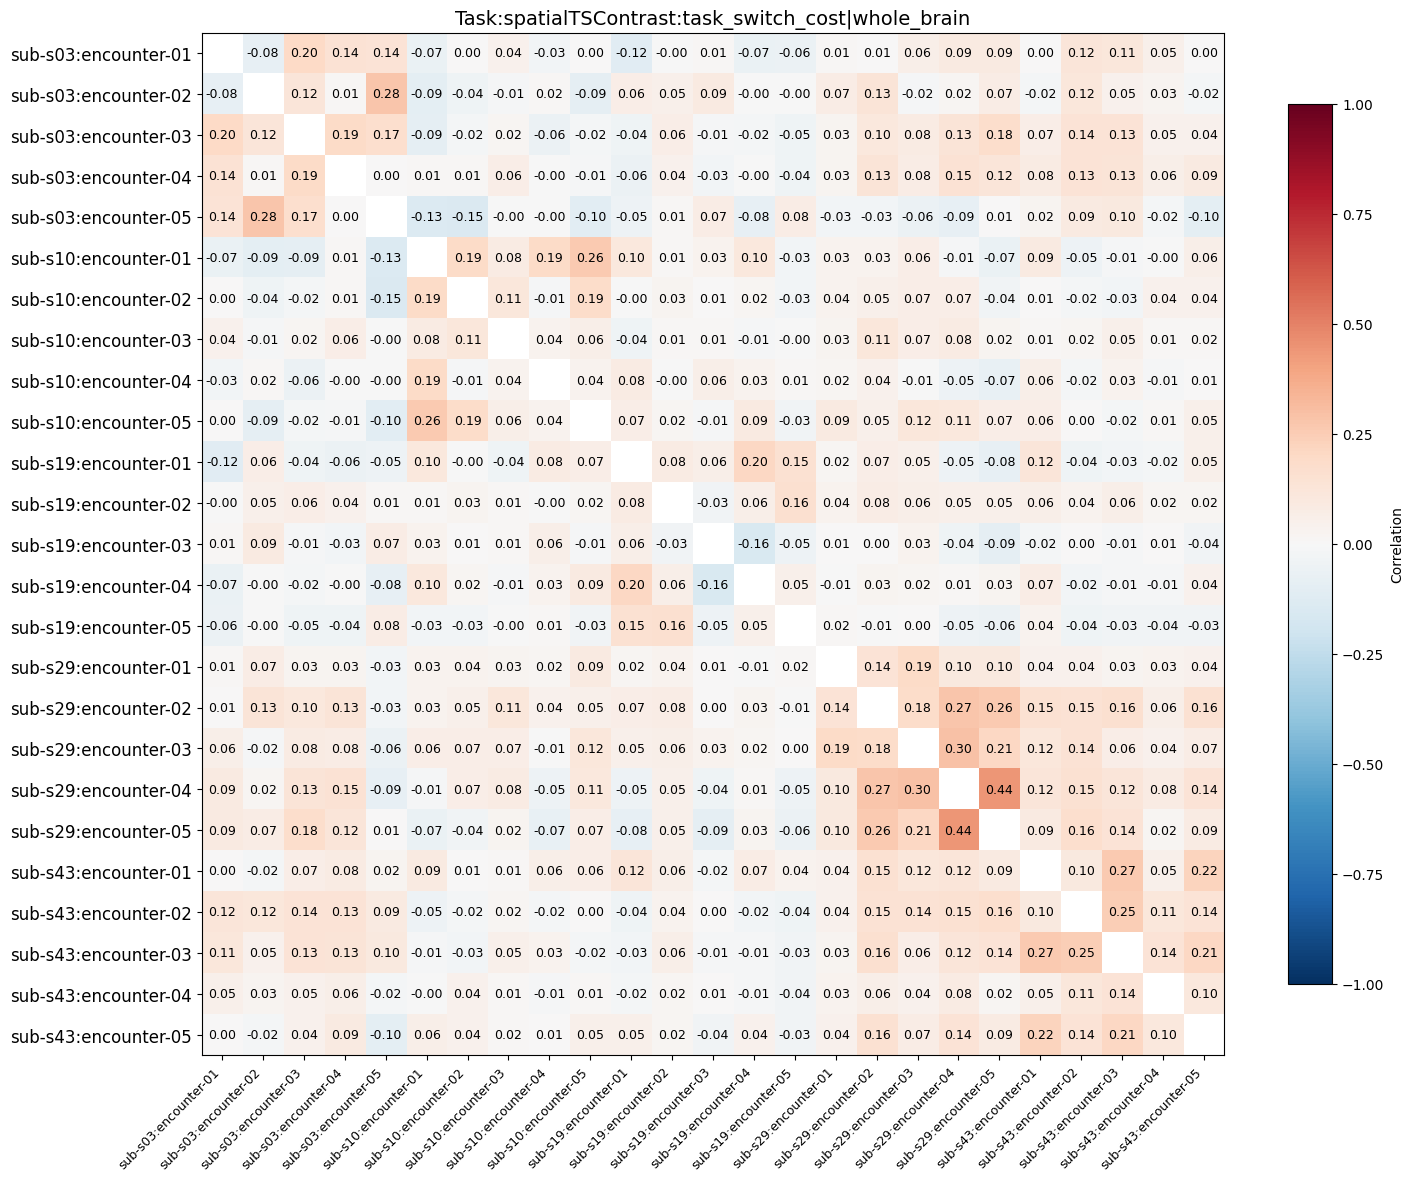

In [9]:
# plot whole brain
for task in requested_task_contrasts.keys():
    for contrast in requested_task_contrasts[task]:
        plot_rsm_clean(all_rsms, task, contrast,'whole_brain')

## Visualizing similarity change across specific networks over time

In [10]:
REGIONS = ["whole_brain", "1_Visual", "2_Somatomotor", "3_Dorsal Attention", "4_Ventral Attention", "5_Limbic",
              "6_Frontoparietal Control", "7_Default Mode"]

In [11]:
regions_of_interest = ["whole_brain", "6_Frontoparietal Control", "7_Default Mode", "3_Dorsal Attention"]

In [14]:
# for each region, go to the task/contrast and save the correlations for enc 0, enc 1, enc 2, etc to a list each
encounter_specific_corrs = {}
for region in REGIONS:
    encounter_specific_corrs[region] = {}

    for task in TASKS:
        encounter_specific_corrs[region][task] = {}

        for contrast in CONTRASTS[task]:
            encounter_specific_corrs[region][task][contrast] = {"1":[], "2":[], "3":[], "4":[], "5":[]}

            rsm_data = all_rsms[task][contrast][region]
            rsm_matrix = rsm_data['rsm']
            descriptors = rsm_data['descriptors']

            # label the data with which encounter each map belongs to
            encounter_map_indices = {}  # encounter_id -> [map indices]
            
            for i, desc in enumerate(descriptors):
                # format: descriptor_name = f"{subject}:encounter-0{encounter + 1}"
                encounter_id = desc.split('encounter-0')[1]
                
                if encounter_id not in encounter_map_indices:
                    encounter_map_indices[encounter_id] = []
                
                encounter_map_indices[encounter_id].append(i)
        
            upper_tri = np.triu_indices_from(rsm_matrix, k=1)
            all_correlations = rsm_matrix[upper_tri]
                        
            for idx, (row, col) in enumerate(zip(upper_tri[0], upper_tri[1])):
                # Find which encounters these two maps belong to
                enc_for_map_row = None
                enc_for_map_col = None
                
                for encounter_id, map_indices in encounter_map_indices.items():
                    if row in map_indices:
                        enc_for_map_row = encounter_id
                    if col in map_indices:
                        enc_for_map_col = encounter_id
                        
                # get the corr
                correlation_value = all_correlations[idx]
        
                # put the corr into assigned group
                # only include if its the same encounter both ways 
                if enc_for_map_row == enc_for_map_col:
                    # Same encounter
                    encounter_specific_corrs[region][task][contrast][enc_for_map_row].append(correlation_value)                    
                    

In [15]:
# Calculate mean between-subject correlation for each encounter (same as before)
encounter_means = {}
for region in REGIONS:
    encounter_means[region] = {}
    for task in TASKS:
        encounter_means[region][task] = {}
        for contrast in CONTRASTS[task]:
            encounter_means[region][task][contrast] = {}
            for encounter in ["1", "2", "3", "4", "5"]:
                corrs = encounter_specific_corrs[region][task][contrast][encounter]
                if corrs:
                    encounter_means[region][task][contrast][encounter] = np.mean(corrs)
                else:
                    encounter_means[region][task][contrast][encounter] = np.nan

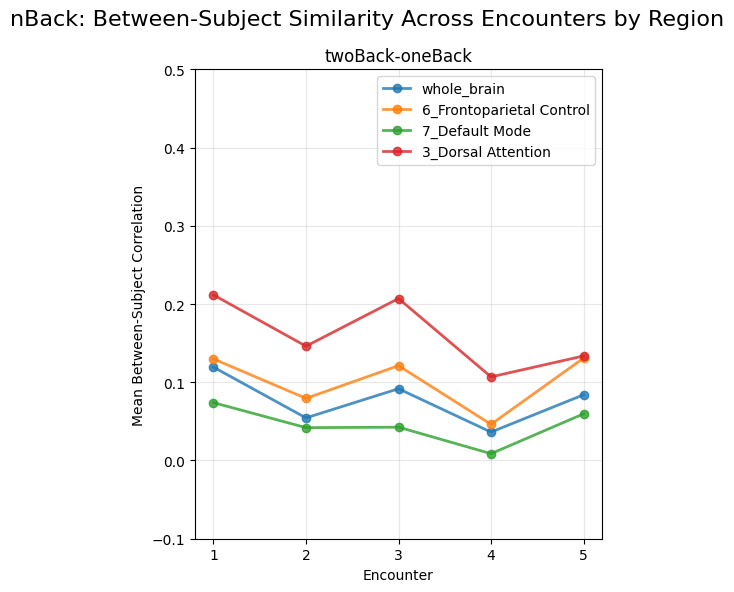

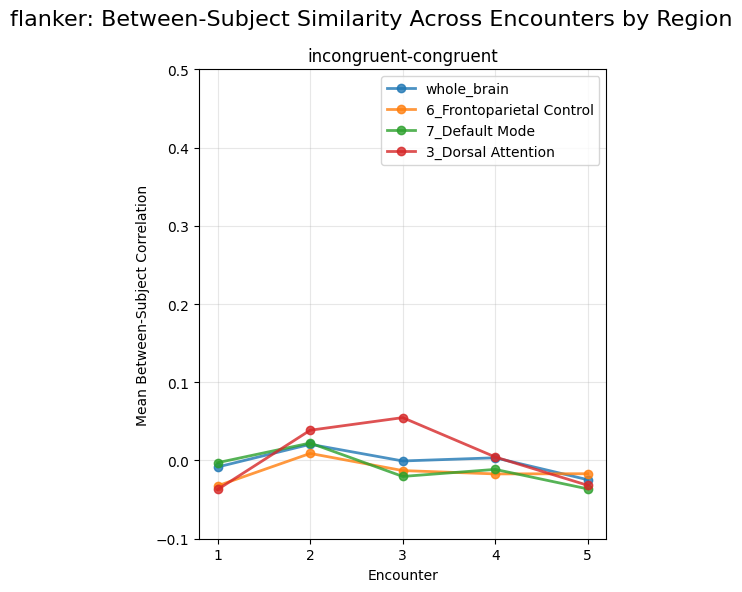

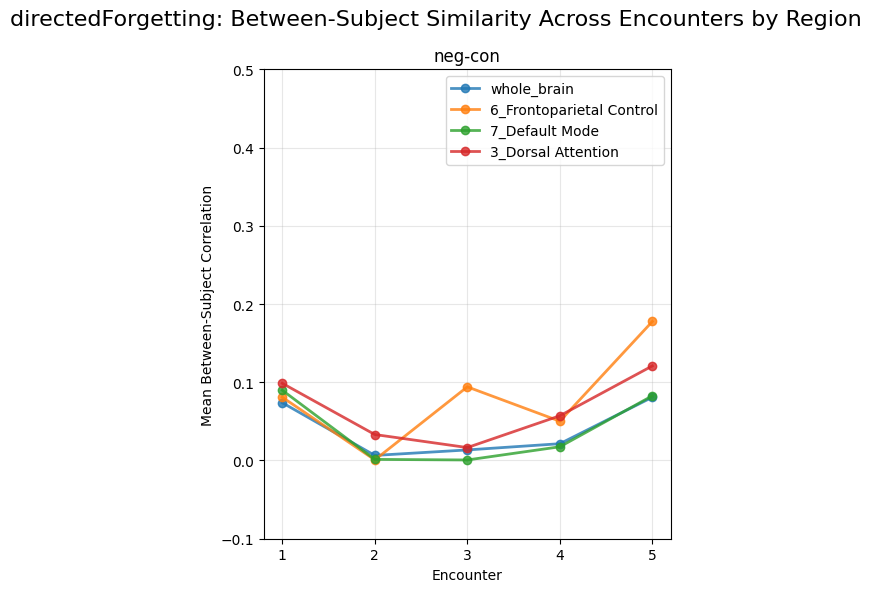

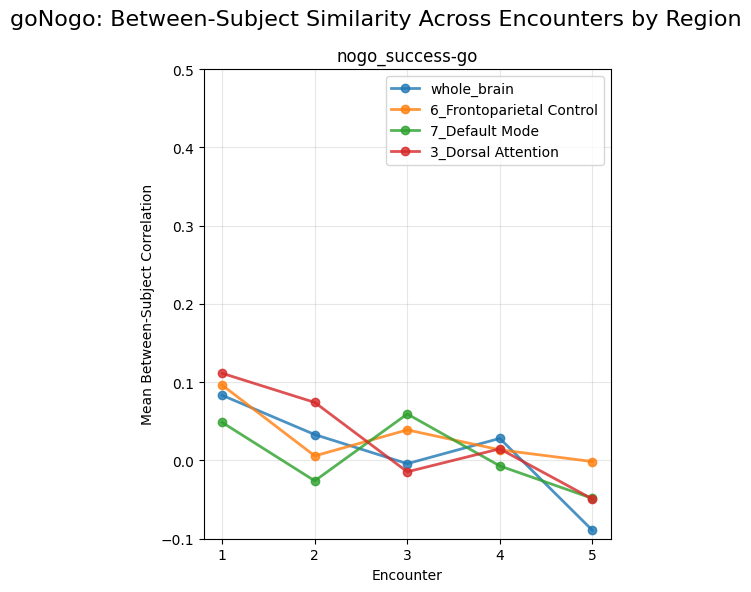

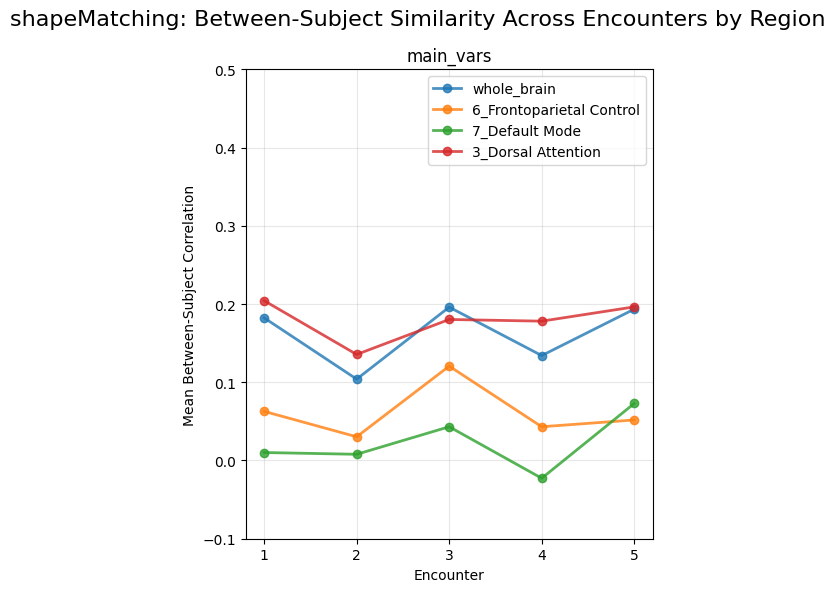

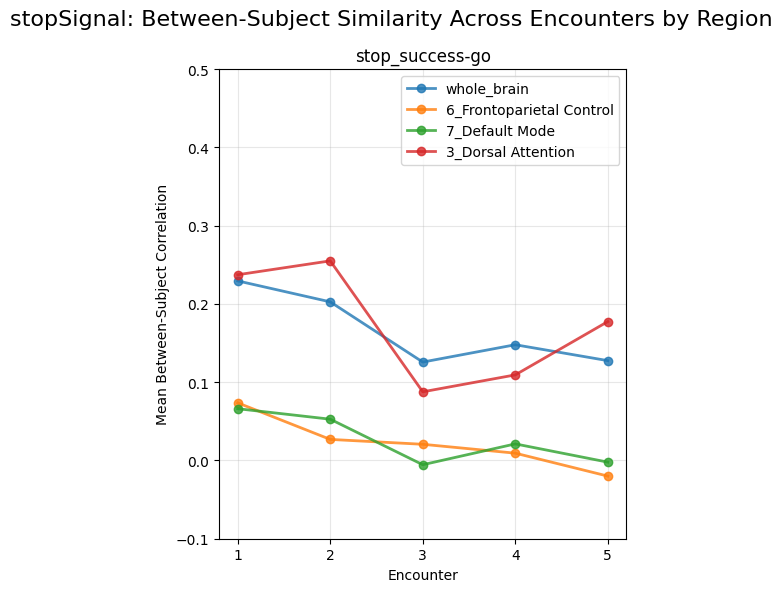

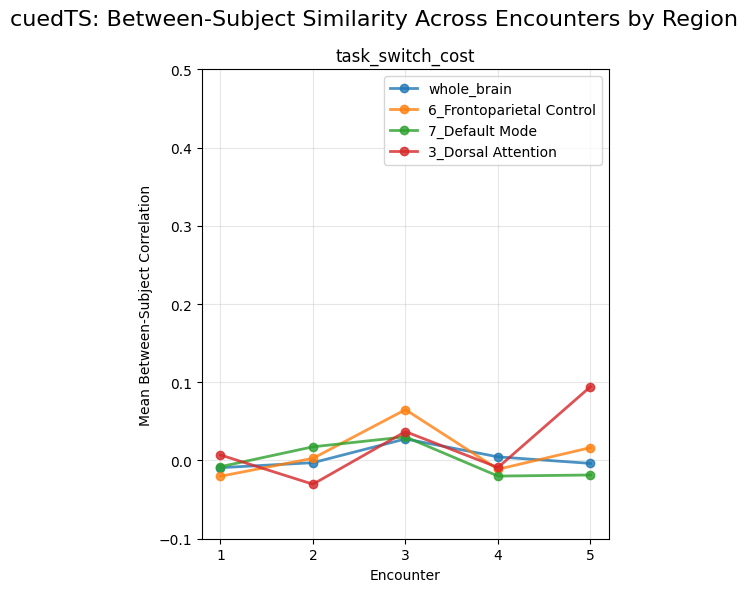

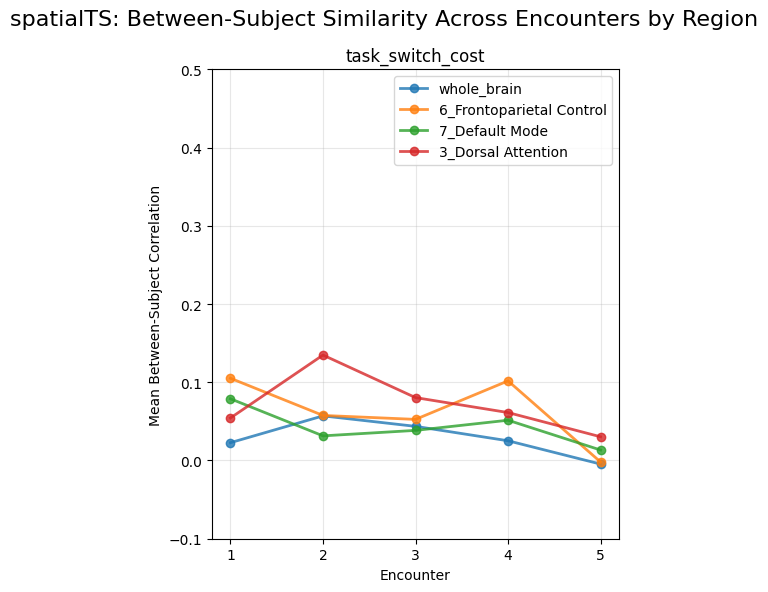

In [18]:
# plot change over time, only for regions of interest and requested_task_contrasts

# 1 plot per task/contrast with all regions
for task in requested_task_contrasts.keys():
    
    fig, ax = plt.subplots(figsize=(5,6))

    for contrast in requested_task_contrasts[task]:
        encounters = ["1", "2", "3", "4", "5"]
        
        # Plot each region as a separate line
        for region in regions_of_interest:
            means = [encounter_means[region][task][contrast][enc] for enc in encounters]
            ax.plot(encounters, means, 'o-', linewidth=2, markersize=6, 
                   label=region, alpha=0.8)
        
        ax.set_xlabel('Encounter')
        ax.set_ylabel('Mean Between-Subject Correlation')
        ax.set_title(f'{contrast}')
        ax.set_ylim(-0.1, 0.5)  # Set the same range for all
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    fig.suptitle(f'{task}: Between-Subject Similarity Across Encounters by Region', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# TODO: plot within subject similarity changing (i.e. encounter 1 ->2 vs 1->3 vs 1->4 etc)